<a href="https://colab.research.google.com/github/micah-shull/Statistics/blob/main/Statistics_29_hypothesis_testing_cars_horsepower_origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Question**:
Do cars from the USA, Europe, and Japan have similar variability in `horsepower`?

---

### **Hypotheses**:
- **Null Hypothesis (H₀)**:  
  The variance in horsepower is the same across all origin groups (USA, Europe, and Japan).  
  *In other words, origin has no effect on the variability of horsepower.*

- **Alternative Hypothesis (H₁)**:  
  At least one origin group has a different variance in horsepower.  
  *In other words, the variability in horsepower differs between origins.*

---

#### **Testing Approach**:
1. Perform **Levene's Test** for equality of variances.
2. Use the test results to determine whether the variances are significantly different.
3. Visualize the spread of `horsepower` across origins using boxplots.





In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

# Load the dataset
cars = sns.load_dataset('mpg')

# Print the number of unique values for each column
unique_counts = cars.nunique()

# Define a threshold for unique values to classify as categorical
threshold = 10

# Identify columns to convert to categorical
categorical_cols = unique_counts[unique_counts < threshold].index.tolist()

# Convert suitable columns to category
for col in categorical_cols:
    cars[col] = cars[col].astype('category')

# Verify the changes
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           398 non-null    float64 
 1   cylinders     398 non-null    category
 2   displacement  398 non-null    float64 
 3   horsepower    392 non-null    float64 
 4   weight        398 non-null    int64   
 5   acceleration  398 non-null    float64 
 6   model_year    398 non-null    int64   
 7   origin        398 non-null    category
 8   name          398 non-null    object  
dtypes: category(2), float64(4), int64(2), object(1)
memory usage: 23.0+ KB
None


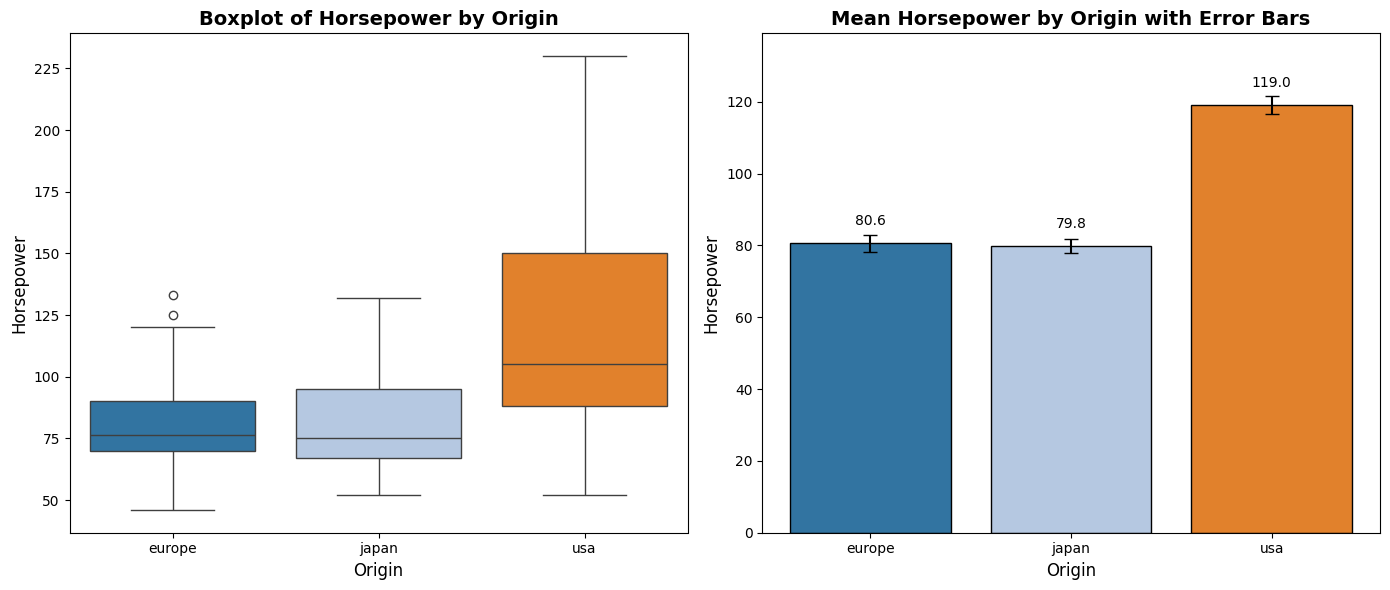

In [ ]:
# Calculate the means, standard deviations, and counts for horsepower by origin
group_stats = cars.groupby('origin', observed=True)['horsepower'].agg(['mean', 'std', 'count']).reset_index()
group_stats['error'] = group_stats['std'] / group_stats['count']**0.5  # Standard error of the mean

# Define the color palette
palette = sns.color_palette("tab20", n_colors=3)

# Set up the figure with a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Boxplot
sns.boxplot(data=cars, x='origin', y='horsepower', hue='origin', palette=palette, ax=axes[0])
axes[0].set_title('Boxplot of Horsepower by Origin', fontsize=14, weight='bold')
axes[0].set_xlabel('Origin', fontsize=12)
axes[0].set_ylabel('Horsepower', fontsize=12)

# Plot 2: Barplot with Error Bars
sns.barplot(data=group_stats, x='origin', y='mean', hue='origin', palette=palette, ax=axes[1], edgecolor='black', errorbar=None)

# Add error bars to the barplot
for index, row in group_stats.iterrows():
    axes[1].errorbar(x=index, y=row['mean'], yerr=row['error'], fmt='none', c='black', capsize=5)

# Add data labels to the barplot
for index, row in group_stats.iterrows():
    axes[1].text(index, row['mean'] + 5, f"{row['mean']:.1f}", ha='center', fontsize=10)

axes[1].set_title('Mean Horsepower by Origin with Error Bars', fontsize=14, weight='bold')
axes[1].set_xlabel('Origin', fontsize=12)
axes[1].set_ylabel('Horsepower', fontsize=12)
axes[1].set_ylim(0, group_stats['mean'].max() + 20)  # Adjust y-axis for labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### **Why Welch's ANOVA?**
1. **Standard ANOVA Assumptions**:
   - Assumes **equal variances** across groups.
   - Assumes the dependent variable is normally distributed within each group.

2. **When to Use Welch's ANOVA**:
   - If **Levene's Test** shows significant differences in variances, the assumption of equal variances for a standard ANOVA is violated.
   - Welch’s ANOVA is a robust alternative that does **not require equal variances**.

3. **Key Difference**:
   - Unlike standard ANOVA, Welch's ANOVA adjusts the F-statistic to account for unequal variances, making it more reliable in your case.

---

### **Why Use the Pingouin Library?**
1. **User-Friendly and Modern**:
   - The `pingouin` library is designed specifically for statistical analysis in Python. It’s clean, simple, and well-documented.
   - It includes modern methods like Welch’s ANOVA, which aren’t available in core Python libraries like `scipy` or `statsmodels`.

2. **Standard Libraries Don’t Have Welch’s ANOVA**:
   - The `scipy.stats` module provides basic ANOVA (`f_oneway`) but does not support Welch’s ANOVA.
   - `statsmodels` is another popular library but requires custom implementations for Welch’s ANOVA.

3. **Output**:
   - `pingouin.welch_anova()` gives a clear and concise output, including the F-statistic, degrees of freedom, and p-value, making it easy to interpret results.


In [ ]:
# !pip install pingouin

In [ ]:
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Drop missing horsepower values
cars = cars.dropna(subset=['horsepower'])

# Group horsepower by origin
usa_hp = cars[cars['origin'] == 'usa']['horsepower']
europe_hp = cars[cars['origin'] == 'europe']['horsepower']
japan_hp = cars[cars['origin'] == 'japan']['horsepower']

# Perform Levene's Test
levene_stat, levene_p = levene(usa_hp, europe_hp, japan_hp)
print(f"Levene's Test Statistic: {levene_stat:.2f}")
print(f"P-Value: {levene_p:.4f}")

# Interpretation
alpha = 0.05
if levene_p < alpha:
    print("\nReject the Null Hypothesis: Variances in horsepower differ across origin groups.")
else:
    print("\nFail to Reject the Null Hypothesis: Variances in horsepower are similar across origin groups.")
print('\n')

# Perform Welch's ANOVA
welch_anova = pg.welch_anova(data=cars, dv='horsepower', between='origin')
print(welch_anova)

# Interpretation
if welch_anova['p-unc'][0] < 0.05:
    print("\nReject the Null Hypothesis: The mean horsepower differs significantly across origin groups.")
else:
    print("\nFail to Reject the Null Hypothesis: The mean horsepower is the same across origin groups.")
print('\n')

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=cars['horsepower'], groups=cars['origin'], alpha=0.05)
print(tukey)

Levene's Test Statistic: 26.53
P-Value: 0.0000

Reject the Null Hypothesis: Variances in horsepower differ across origin groups.


   Source  ddof1       ddof2          F         p-unc       np2
0  origin      2  194.585614  84.843672  3.203261e-27  0.239765

Reject the Null Hypothesis: The mean horsepower differs significantly across origin groups.


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
europe  japan  -0.7234 0.9907 -13.8185 12.3717  False
europe    usa  38.4902    0.0  27.6396 49.3407   True
 japan    usa  39.2135    0.0  28.9713 49.4558   True
-----------------------------------------------------


### **Interpretation of the Results**

#### **1. Levene's Test for Variances**
- **Test Statistic**: 26.53  
- **P-Value**: 0.0000  
  - The p-value is far below \( \alpha = 0.05 \), so we **reject the null hypothesis**.
  - Conclusion: The variances in `horsepower` differ significantly across the `origin` groups (USA, Europe, Japan). This is why Welch’s ANOVA was chosen instead of standard ANOVA.

---

#### **2. Welch’s ANOVA**
- **F-Statistic**: 84.84  
- **P-Value**: \( 3.20 \times 10^{-27} \) (effectively 0)  
  - The p-value is far below \( \alpha = 0.05 \), so we **reject the null hypothesis**.
  - Conclusion: The mean horsepower differs significantly across at least one pair of origin groups.
- **Partial Eta Squared (\( \eta^2_p \))**: 0.24  
  - This indicates that 24% of the variability in `horsepower` can be attributed to differences between the `origin` groups. This is a moderate-to-large effect size.

---

#### **3. Tukey’s HSD Test (Post-Hoc Analysis)**

1. **Europe vs. Japan**:
   - Mean Difference: -0.72  
   - \( p = 0.9907 \): Not significant.  
   - Conclusion: No significant difference in mean horsepower between Europe and Japan.

2. **Europe vs. USA**:
   - Mean Difference: 38.49  
   - \( p = 0.0000 \): Highly significant.  
   - Conclusion: USA cars have significantly higher mean horsepower than Europe cars.

3. **Japan vs. USA**:
   - Mean Difference: 39.21  
   - \( p = 0.0000 \): Highly significant.  
   - Conclusion: USA cars have significantly higher mean horsepower than Japan cars.

---

### **Summary of Results**
1. **Variances**:
   - Variances in horsepower differ significantly between origins.
2. **Means**:
   - The mean horsepower differs significantly across the origins.
   - **USA cars** have the highest mean horsepower, significantly higher than both Europe and Japan.
   - **Europe and Japan cars** have similar mean horsepower.
3. **Effect Size**:
   - A large proportion (24%) of the variability in horsepower is explained by origin.

